In [31]:
# Standard Libraries
import os
import glob
import time
import random
import datetime
import numpy as np
import pandas as pd
import scipy
from scipy import optimize
from scipy.stats import multivariate_normal
import seaborn as sns

# Visualization Libraries
import matplotlib
matplotlib.use('TkAgg', force=True)
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set(style="ticks", color_codes=True)
import missingno

# Image Processing Libraries
import PIL
import imageio

# IPython Display
from IPython import display

# PyMC for Bayesian Modeling
import pymc as pm
import arviz as az

# Scikit-Learn Libraries
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.datasets import make_moons, make_blobs
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                             precision_score, recall_score, f1_score, roc_auc_score, 
                             average_precision_score, roc_curve, precision_recall_curve, 
                             ConfusionMatrixDisplay, make_scorer, matthews_corrcoef)

# XGBoost classique
import xgboost as xgb



### Import des données 

In [2]:
# Chargement des données
X_train = pd.read_csv("data/X_train.csv", parse_dates=['DELIVERY_START'])

X_test = pd.read_csv("data/X_test.csv", parse_dates=['DELIVERY_START'])

y_train = pd.read_csv("data/y_train.csv", parse_dates=['DELIVERY_START'])

In [3]:
X_train.describe()

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
count,9318.000000,10604.000000,10604.000000,10604.000000,10581.000000,10581.000000,10581.000000,10581.000000,1846.000000
mean,53725.132968,2819.781592,11463.220671,35393.282252,4512.989415,1919.281353,125.399422,24.997384,140.256024
std,11274.194929,495.103588,483.799154,7619.820162,3349.419356,2706.963383,132.152875,43.083977,33.922669
min,30515.000000,1646.000000,9769.000000,22285.000000,592.000000,0.000000,1.830211,0.000000,42.420000
25%,45336.500000,2226.000000,11140.000000,29005.000000,2036.000000,0.000000,46.818974,0.000000,119.405000
50%,51846.000000,2806.000000,11487.000000,32470.000000,3319.000000,149.000000,86.700163,3.507229,140.040000
75%,62091.750000,3386.000000,11945.000000,43055.000000,5951.000000,3507.000000,155.325644,35.137019,160.765000
max,85145.000000,3391.000000,11963.000000,50122.000000,15167.000000,10127.000000,1871.571992,745.261316,254.190000


In [4]:
X_train.head(10)

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
0,2022-01-01 02:00:00+01:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.000000,NaN
1,2022-01-01 03:00:00+01:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.000000,NaN
2,2022-01-01 04:00:00+01:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.000000,NaN
3,2022-01-01 05:00:00+01:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.000000,NaN
4,2022-01-01 06:00:00+01:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.000000,NaN
5,2022-01-01 07:00:00+01:00,45648.0,3386.0,11487.0,44118.0,3902.0,0.0,27.624052,0.000000,NaN
6,2022-01-01 08:00:00+01:00,45909.0,3386.0,11487.0,44118.0,4092.0,198.0,44.944701,6.195349,NaN
7,2022-01-01 09:00:00+01:00,47091.0,3386.0,11487.0,44118.0,4315.0,1012.0,30.505330,23.239957,NaN
8,2022-01-01 10:00:00+01:00,48300.0,3386.0,11487.0,44118.0,4436.0,2401.0,35.835910,44.450154,NaN
9,2022-01-01 11:00:00+01:00,49559.0,3386.0,11487.0,44118.0,4459.0,3699.0,57.670945,53.426489,NaN


### Pre-traitement

In [5]:
# Check
X_train.info()
X_test.info()

X_train.isnull().sum()
X_train.isnull().mean()*100

X_test.isnull().sum()
X_test.isnull().mean()*100

print(X_train.isna().sum(),
     X_test.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10605 entries, 0 to 10604
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DELIVERY_START                 10605 non-null  object 
 1   load_forecast                  9318 non-null   float64
 2   coal_power_available           10604 non-null  float64
 3   gas_power_available            10604 non-null  float64
 4   nucelear_power_available       10604 non-null  float64
 5   wind_power_forecasts_average   10581 non-null  float64
 6   solar_power_forecasts_average  10581 non-null  float64
 7   wind_power_forecasts_std       10581 non-null  float64
 8   solar_power_forecasts_std      10581 non-null  float64
 9   predicted_spot_price           1846 non-null   float64
dtypes: float64(9), object(1)
memory usage: 828.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4942 entries, 0 to 4941
Data columns (total 10 columns):
 #   Colum

In [8]:
# Matrice de valeurs manquantes
missingno.matrix(X_train)
plt.show()

In [9]:
# On peut soit drop "predictes_spot_price" soit utiliser une méthode d'imputation des données
# car vraiment bcp de valeurs manquantes pour cette feature.
imputer = SimpleImputer(strategy='mean')
X_train.iloc[:, 1:9] = imputer.fit_transform(X_train.iloc[:, 1:9])
X_test.iloc[:, 1:9] = imputer.fit_transform(X_test.iloc[:, 1:9])

print(X_train.isna().sum(),
     X_test.isna().sum())

DELIVERY_START                      0
load_forecast                       0
coal_power_available                0
gas_power_available                 0
nucelear_power_available            0
wind_power_forecasts_average        0
solar_power_forecasts_average       0
wind_power_forecasts_std            0
solar_power_forecasts_std           0
predicted_spot_price             8759
dtype: int64 DELIVERY_START                      0
load_forecast                       0
coal_power_available                0
gas_power_available                 0
nucelear_power_available            0
wind_power_forecasts_average        0
solar_power_forecasts_average       0
wind_power_forecasts_std            0
solar_power_forecasts_std           0
predicted_spot_price             1536
dtype: int64


In [10]:
X_train = X_train.drop(["predicted_spot_price"], axis=1)
X_test = X_test.drop(["predicted_spot_price"], axis=1)

In [11]:

# Constructions de quelques features supplémentaires
X_train['DELIVERY_START'] = pd.to_datetime(X_train['DELIVERY_START'], utc=True)
X_test['DELIVERY_START'] =  pd.to_datetime(X_test['DELIVERY_START'], utc=True)

for df in [X_train, X_test]:
    df['hour'] = df['DELIVERY_START'].dt.hour
    df['day'] = df['DELIVERY_START'].dt.dayofweek
    df['month'] = df['DELIVERY_START'].dt.month


    df['total_power'] = (df['coal_power_available'] + 
                                   df['gas_power_available'] + 
                                   df['nucelear_power_available'])
    df['total_renewable'] = (df['wind_power_forecasts_average'] + 
                                      df['solar_power_forecasts_average'])

    df['load_to_total_power_ratio'] = df['load_forecast'] / df['total_power']
    df['renewable_to_nonrenewable_ratio'] = df['total_renewable'] / df['total_power']
    
    #rajouter des valeurs laggées genre 24 pour un jour avant

#X_train = X_train.drop(["predicted_spot_price"], axis=1)
X_train.set_index("DELIVERY_START", inplace=True)

#X_test = X_test.drop(["predicted_spot_price"], axis=1)
X_test.set_index("DELIVERY_START", inplace=True)

In [12]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Pour aborder le problème par l'angle de classif
y_train['DELIVERY_START'] = pd.to_datetime(y_train["DELIVERY_START"], utc=True)
y_train.set_index("DELIVERY_START", inplace=True)
y_train["spot_id_delta"] = np.where(y_train["spot_id_delta"]>0, 1, 0)

In [13]:
# Redecoupage pour faire des test car on a pas le y_test
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
X_train2_scaled = scaler.fit_transform(X_train2)
X_test2_scaled = scaler.fit_transform(X_test2)

# Formattage pour éviter les erreurs
y_train2 = np.ravel(y_train2)
y_test2 = np.ravel(y_test2)

In [14]:
print(X_train.isna().sum(),
     X_test.isna().sum())

load_forecast                      0
coal_power_available               0
gas_power_available                0
nucelear_power_available           0
wind_power_forecasts_average       0
solar_power_forecasts_average      0
wind_power_forecasts_std           0
solar_power_forecasts_std          0
hour                               0
day                                0
month                              0
total_power                        0
total_renewable                    0
load_to_total_power_ratio          0
renewable_to_nonrenewable_ratio    0
dtype: int64 load_forecast                      0
coal_power_available               0
gas_power_available                0
nucelear_power_available           0
wind_power_forecasts_average       0
solar_power_forecasts_average      0
wind_power_forecasts_std           0
solar_power_forecasts_std          0
hour                               0
day                                0
month                              0
total_power              

### Modèles

##### Régression logistique

In [15]:
# Modèle de base avec fit classique
model = LogisticRegression(random_state=42)
model.fit(X_train2_scaled, y_train2)
y_pred = model.predict(X_test2_scaled)

print("Confusion Matrix:")
cm = confusion_matrix(y_test2, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=model.classes_).plot()
plt.show()
print("\nClassification Report:")
print(classification_report(y_test2, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test2, y_pred))

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.53      0.52      1725
           1       0.53      0.51      0.52      1775

    accuracy                           0.52      3500
   macro avg       0.52      0.52      0.52      3500
weighted avg       0.52      0.52      0.52      3500


Accuracy Score:
0.5188571428571429


In [16]:
# Nested Cross-validation avec reg log

# Metric MCC mais d'autres peuvent être dispo (f1, roc auc, rec, pre)
scorer = make_scorer(matthews_corrcoef)
reg_log =  LogisticRegression(penalty='l2', random_state=1, solver='lbfgs')
param_grid = {'C': [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
rs = RandomizedSearchCV(estimator=model,
                        param_distributions=param_grid,
                        scoring=scorer,
                        refit=True,
                        n_iter=12,
                        cv=cv,
                        random_state=1,
                        n_jobs=-1)


rs.fit(X_train2_scaled, y_train2)
print("Best parameters found: ", rs.best_params_)
print("Best cross-validation score: ", rs.best_score_)

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

nested_scores = cross_val_score(rs, X_train2_scaled, y_train2, 
                                scoring=scorer, cv=inner_cv, n_jobs=-1)
print(f'Nested CV score: {np.mean(nested_scores):.3f} '
      f'+/- {np.std(nested_scores):.3f}')

c:\Users\aikan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aikan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\aikan\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\aikan\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\aikan\anaconda3\Lib\site-packages\sk

Best parameters found:  {'C': 10}
Best cross-validation score:  0.0435185898603503
Nested CV score: 0.043 +/- 0.018


##### Majority voting

In [17]:
# Combinaison de classifieur avec le majority voting
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [18]:
voting_clf.fit(X_train2_scaled, y_train2)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf',
                              RandomForestClassifier(n_estimators=500,
                                                     random_state=42)),
                             ('svc', SVC(random_state=42))])

In [19]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train2_scaled, y_train2)
    y_pred = clf.predict(X_test2_scaled)
    print(clf.__class__.__name__, accuracy_score(y_test2, y_pred))

LogisticRegression 0.5188571428571429
RandomForestClassifier 0.7808571428571428
SVC 0.6194285714285714
VotingClassifier 0.6828571428571428


In [20]:
# Soft voting
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)

svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

In [21]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train2_scaled, y_train2)
    y_pred = clf.predict(X_test2_scaled)
    print(clf.__class__.__name__, accuracy_score(y_test2, y_pred))

LogisticRegression 0.5188571428571429
RandomForestClassifier 0.7808571428571428
SVC 0.6194285714285714
VotingClassifier 0.7414285714285714


##### Random forest

In [22]:
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train2_scaled, y_train2)

y_pred_rf = rf.predict(X_test2_scaled)
accuracy_score(y_test2, y_pred_rf)

0.7808571428571428

In [23]:
# Avec nested CV
rf_clf = RandomForestClassifier(n_estimators=500 ,random_state=1)
scorer = make_scorer(matthews_corrcoef)

param_grid = {
    'max_depth': [None,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]}

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

rs = RandomizedSearchCV(estimator=rf_clf,
                        param_distributions=param_grid,
                        scoring=scorer,
                        refit=True,
                        n_iter=12,
                        cv=inner_cv,
                        random_state=1,
                        n_jobs=-1)


rs.fit(X_train2_scaled, y_train2)
print("Best parameters found: ", rs.best_params_)
print("Best cross-validation score: ", rs.best_score_)


nested_scores = cross_val_score(rs, X_train2_scaled, y_train2, 
                                scoring=scorer, cv=outer_cv, n_jobs=-1)
print(f'Nested CV score: {np.mean(nested_scores):.3f} '
      f'+/- {np.std(nested_scores):.3f}')


Best parameters found:  {'max_depth': None}
Best cross-validation score:  0.534762111035209
Nested CV score: 0.533 +/- 0.021


##### AdaBoost

In [24]:
tree = DecisionTreeClassifier(max_depth=1, random_state=1)
ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1)

ada = ada.fit(X_train2_scaled, y_train2)
y_train_pred = ada.predict(X_train2_scaled)
y_test_pred = ada.predict(X_test2_scaled)

ada_train = accuracy_score(y_train2, y_train_pred) 
ada_test = accuracy_score(y_test2, y_test_pred) 
print(f'AdaBoost train/test accuracies '
      f'{ada_train:.3f}/{ada_test:.3f}')

c:\Users\aikan\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoost train/test accuracies 0.613/0.577


In [25]:
# Avec nested CV
ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1)
scorer = make_scorer(matthews_corrcoef)

param_grid = {'learning_rate': np.linspace(0.01, 0.1, 12)}

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)


rs = RandomizedSearchCV(estimator=ada,
                        param_distributions=param_grid,
                        scoring=scorer,
                        refit=True,
                        n_iter=12,
                        cv=inner_cv,
                        random_state=1,
                        n_jobs=-1)


rs.fit(X_train2_scaled, y_train2)
print("Best parameters found: ", rs.best_params_)
print("Best cross-validation score: ", rs.best_score_)


nested_scores = cross_val_score(rs, X_train2_scaled, y_train2, 
                                scoring=scorer, cv=outer_cv, n_jobs=-1)
print(f'Nested CV accuracy: {np.mean(nested_scores):.3f} '
      f'+/- {np.std(nested_scores):.3f}')


c:\Users\aikan\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Best parameters found:  {'learning_rate': 0.08363636363636363}
Best cross-validation score:  0.15695722122661998
Nested CV accuracy: 0.152 +/- 0.027


##### XGBoost

In [29]:
# Généralement un learning rate entre 0.01 and 0.1
xgbc = xgb.XGBClassifier(n_estimators=5000, learning_rate=0.01, max_depth=4, random_state=42, use_label_encoder=False)

gbm = xgbc.fit(X_train2_scaled, y_train2)

y_train_pred = gbm.predict(X_train2_scaled)
y_test_pred = gbm.predict(X_test2_scaled)

gbm_train = accuracy_score(y_train2, y_train_pred) 
gbm_test = accuracy_score(y_test2, y_test_pred) 
print(f'XGboost train/test accuracies '
      f'{gbm_train:.3f}/{gbm_test:.3f}')

XGboost train/test accuracies 0.898/0.644


In [47]:
# Avec Nested CV

xgb_clf = xgb.XGBClassifier(n_estimators=5000, 
                            random_state=42, 
                            use_label_encoder=False, 
                            eval_metric='logloss')
scorer = make_scorer(matthews_corrcoef)

param_grid = {
    'max_depth': np.linspace(2, 20, 11, dtype=int),
    'learning_rate': np.linspace(0.01, 0.1, 11)
}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

rs = RandomizedSearchCV(estimator=xgb_clf,
                        param_distributions=param_grid,
                        scoring=scorer,
                        refit=True,
                        n_iter=12,
                        cv=inner_cv,
                        random_state=42,
                        n_jobs=-1)

rs.fit(X_train2_scaled, y_train2)
print("Best parameters found: ", rs.best_params_)
print("Best cross-validation score: ", rs.best_score_)

nested_scores = cross_val_score(rs, X_train2_scaled, y_train2, 
                                scoring=scorer, cv=outer_cv, n_jobs=-1)
print(f'Nested CV MCC: {np.mean(nested_scores):.3f} '
      f'+/- {np.std(nested_scores):.3f}')

Best parameters found:  {'max_depth': 20, 'learning_rate': 0.01}
Best cross-validation score:  0.5105276793334005


: 

## Courbes d'apprentissage et de validation

In [32]:
xgb_clf_opti = xgb.XGBClassifier(n_estimators=5000, 
                            random_state=42, 
                            use_label_encoder=False, 
                            eval_metric='logloss', 
                            max_depth=20, 
                           learning_rate=0.01)

Strat_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

train_sizes, train_scores, test_scores = learning_curve(estimator=xgb_clf_opti,
                                                        X=X_train2_scaled,
                                                        y=y_train2,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=Strat_kfold,
                                                        n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

## Courbes ROC

In [27]:

%matplotlib inline

def roc_curve(classifier, cv, X, y, title='ROC Curve'):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


def draw_cv_pr_curve(classifier, cv, X, y, title='PR Curve'):
    y_real = []
    y_proba = []

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        precision, recall, _ = precision_recall_curve(y[test], probas_[:, 1])
        
        # Plotting each individual PR Curve
        plt.plot(recall, precision, lw=1, alpha=0.3,
                 label='PR fold %d (AUC = %0.2f)' % (i, average_precision_score(y[test], probas_[:, 1])))
        
        y_real.append(y[test])
        y_proba.append(probas_[:, 1])

        i += 1
    
    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    
    precision, recall, _ = precision_recall_curve(y_real, y_proba)

    plt.plot(recall, precision, color='b',
             label=r'Precision-Recall (AUC = %0.2f)' % (average_precision_score(y_real, y_proba)),
             lw=2, alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

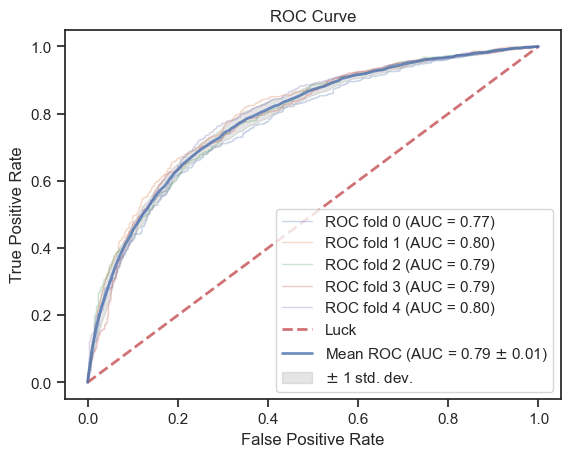

In [28]:
xgb_clf_opti = xgb.XGBClassifier(n_estimators=5000, 
                            random_state=42, 
                            use_label_encoder=False, 
                            eval_metric='logloss', 
                            max_depth=20, 
                           learning_rate=0.01)
stratcv = StratifiedKFold(n_splits=10)
draw_cv_roc_curve(xgb_clf_opti, stratcv, X_train2_scaled, y_train2)

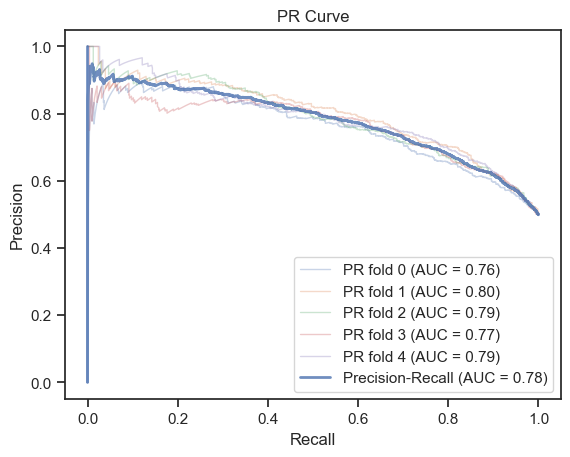

In [31]:
draw_cv_pr_curve(xgb_clf_opti, stratcv, X_train2_scaled, y_train2)

# Classification avec ACP

In [ ]:
#Normalisation des données

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)